In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import style

#One-hot encodding
from sklearn.preprocessing import LabelBinarizer

#Progress bars
from tqdm import tqdm
tqdm.pandas(ascii=True)

#Paralelize pandas apply on multiple cores
import swifter

#Nicer style
style.use('seaborn-v0_8') 
# style.available

In [2]:
import re #regexp

NLTK based on regex

In [3]:
from nltk.tokenize import RegexpTokenizer

### Cleaning the dataset
We load the news dataset

C:\Users\hp\AppData\Local\Temp\ipykernel_2204\245784337.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  news = pd.read_csv("../data/news_sample.csv", nrows=200_000)


,content,title
type,,
conspiracy,7511,7511
fake,45867,45867
hate,304,304
junksci,2233,2233
political,79591,79591
reliable,316,316
rumor,124,124
satire,383,383
unknown,1477,1477


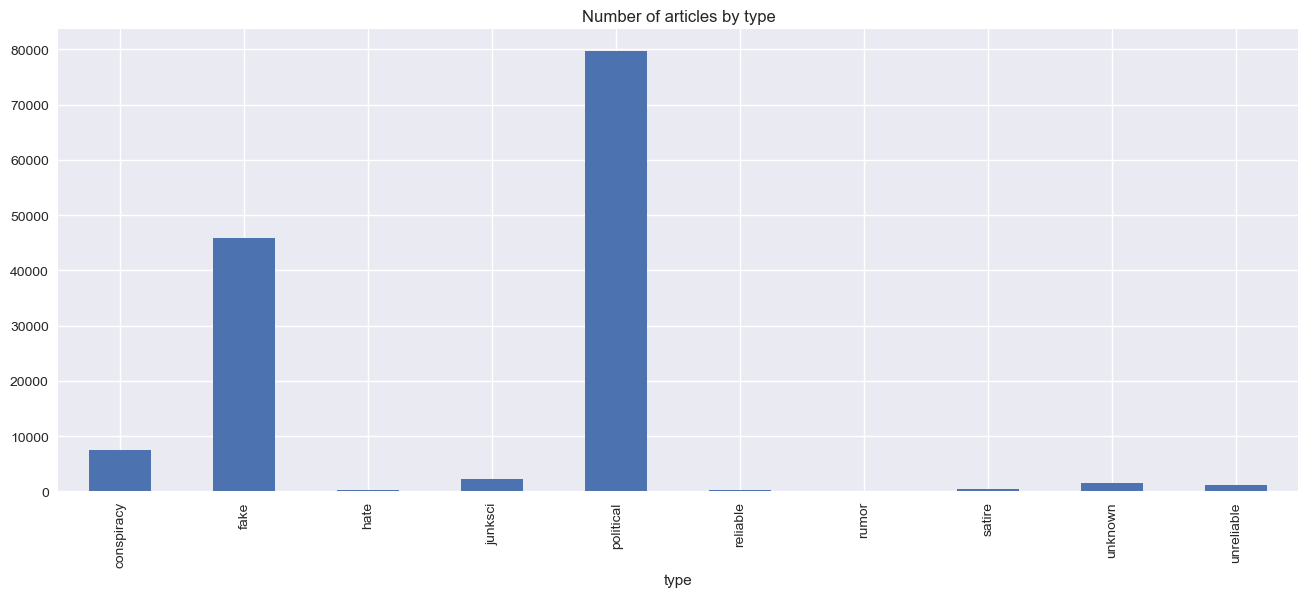

In [4]:
news = pd.read_csv("../data/news_sample.csv", nrows=200_000)
news = news[news['type']!='bias']
news = news[news['type']!='clickbait']

# #Load dataset for avoiding unbalance.
# click_bias = pd.read_csv("../data/click_bias.csv", nrows=200_000)

# news = pd.concat([news, click_bias])

# del(click_bias)

fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

news = news[['type', 'content', 'title']]

#Remove columns with NaNs 
news = news.dropna()
news.groupby("type").count()

Fixing the dataset bias imbalance

In [5]:
news = pd.concat([news[news['type'] == 'political'].head(60000).copy(), news[news['type'] != 'political'].copy()])

<Axes: title={'center': 'Number of articles by type'}, xlabel='type'>

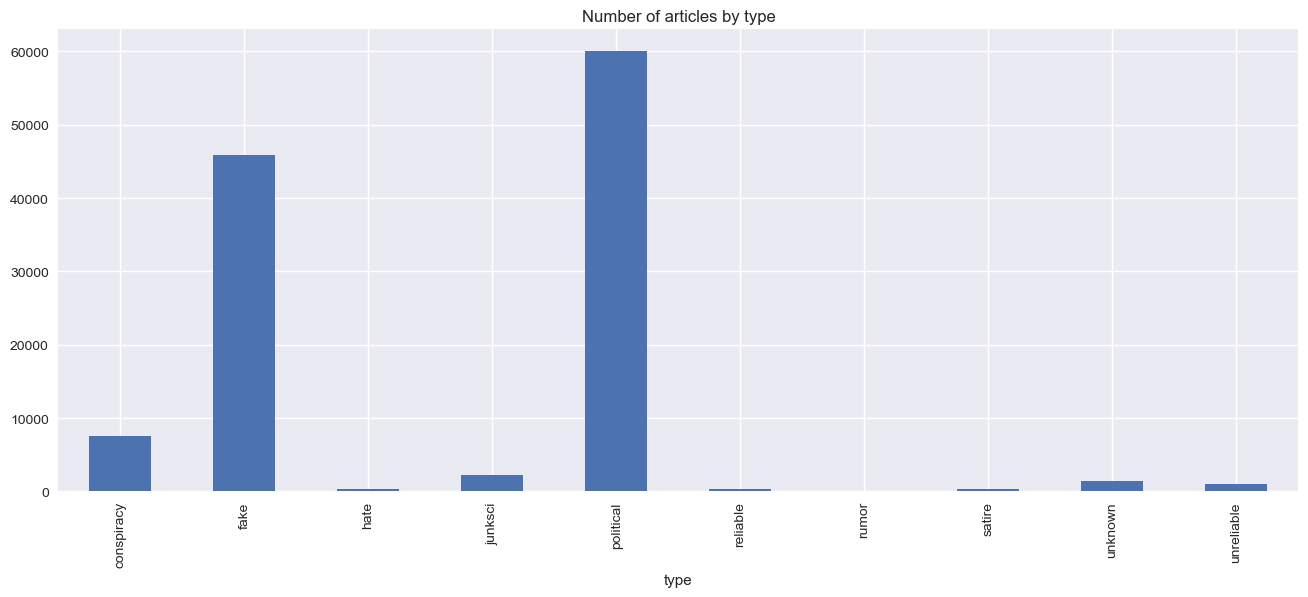

In [6]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

In [7]:
def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]    
    return words

<>:5: SyntaxWarning: invalid escape sequence '\w'
<>:5: SyntaxWarning: invalid escape sequence '\w'
C:\Users\hp\AppData\Local\Temp\ipykernel_2204\2108186692.py:5: SyntaxWarning: invalid escape sequence '\w'
  tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')


We clean the fields that we will use : title and content

In [8]:
#Clean content
news['content'] = news.swifter.apply(lambda row: clean_text(row['content']), axis=1)
#Clean title
news['title'] = news.swifter.apply(lambda row: clean_text(row['title']), axis=1)

#Select only news with text
news = news[news['title'].str.len() >= 1]
news = news[news['content'].str.len() >= 1]

Pandas Apply:   0%|          | 0/119295 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/119295 [00:00<?, ?it/s]

In [9]:
news.head(3)

,type,content,title
136,political,"[It, is, rather, hard, to, write, with, eclips...","[Finding, wonder, and, foreboding, in, the, pa..."
137,political,"[As, our, nation, celebrated, Labor, Day, givi...","[God, works, we, work, Baptist, News, Global]"
158,political,"[We, hear, quite, a, bit, about, survivors, gu...","[Does, God, play, favorites, Baptist, News, Gl..."


The news is organized into the following categories

<Axes: title={'center': 'Number of articles by type'}, xlabel='type'>

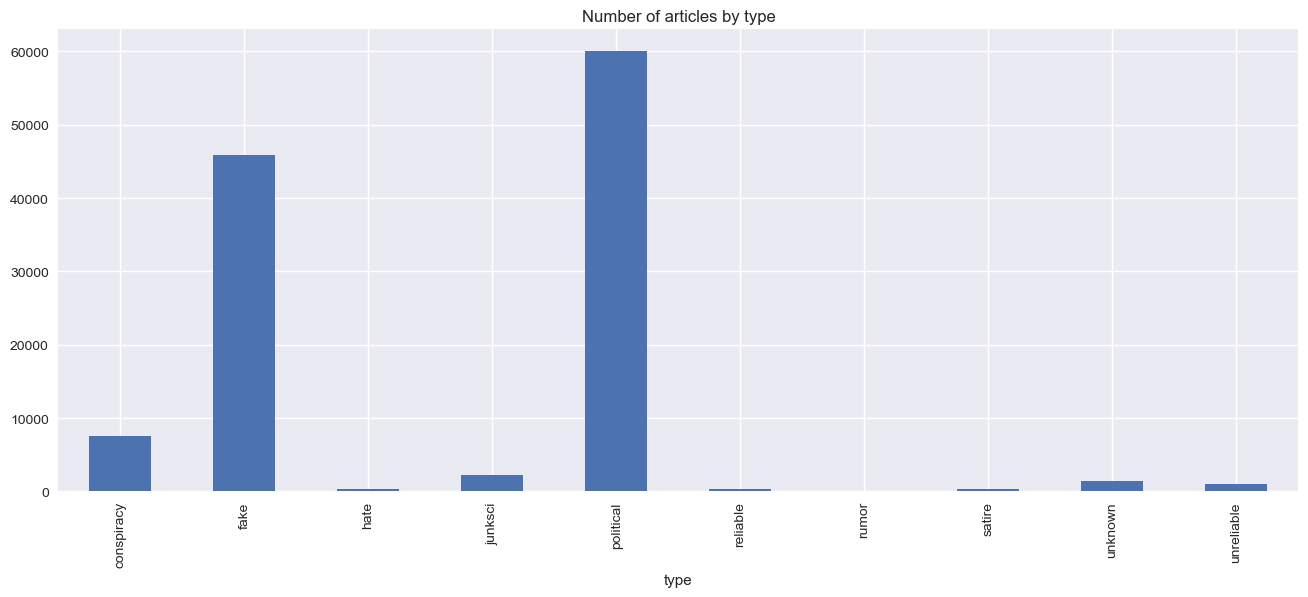

In [10]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

Types according to dataset provider
   * **Fake**
       * conspiracy
       * junksci
       * rumor
       * unknown
       * satire
       * hate
       * unreliable
       * fake
   * **Bias**
       * bias
   * **Truth**
       * reliable
       * political
   * **Clickbait**
       * clickbait

We turned the groups into new ones.

In [11]:
def convert_tag(tag):
    """Convert a tag into one of these groups (fake, truth, clickbait)"""
    new_tag = None
    fake = set(['conspiracy', 'junksci', 'rumor', 'unknown', 'satire', 'hate', 'unreliable', 'fake'])
    truth = set(['reliable', 'political'])
    click = set(['clickbait'])
    bias = set(['bias'])
    
    if tag in fake:
        new_tag = 'fake'
    if tag in truth:
        new_tag = 'truth'
    if tag in click:
        new_tag = 'click'
    if tag in bias:
        new_tag = 'bias'
        
    return new_tag

In [12]:
news['type'] = news.swifter.apply(lambda row: convert_tag(row['type']), axis=1)

Pandas Apply:   0%|          | 0/119252 [00:00<?, ?it/s]

<Axes: title={'center': 'Number of articles by type'}, xlabel='type'>

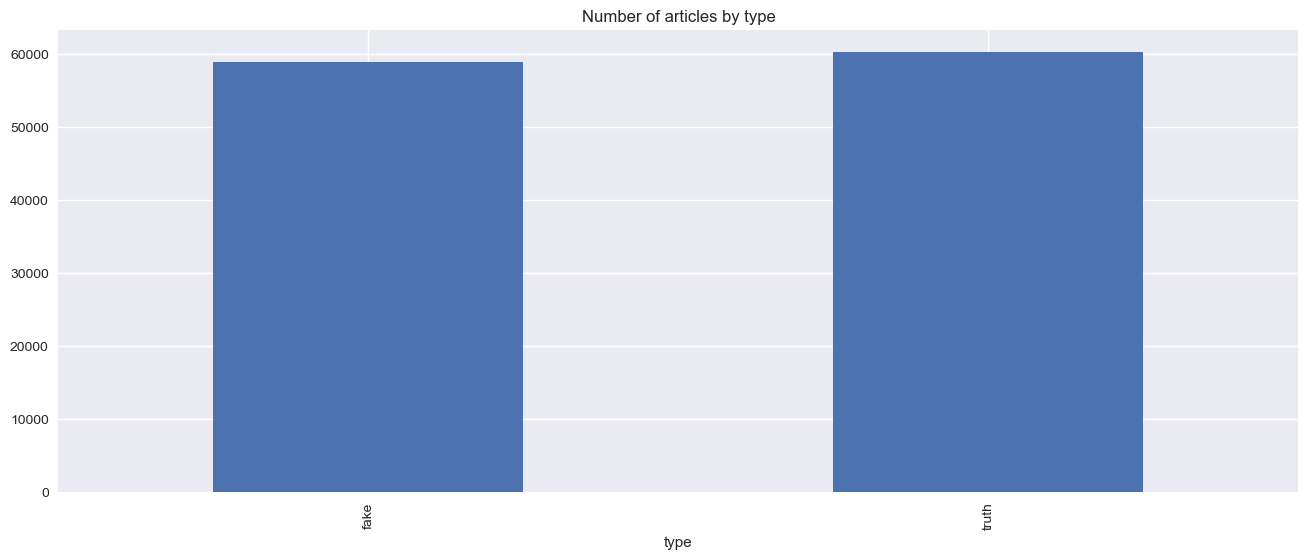

In [13]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

The dataset is quite unbalanced. In order to train the NN correctly. The numbers of samples per category must be more equal

In this case we create a function to select the examples we want for each category. Those that are underrepresented will be oversampled

In [53]:
def equalize_categories(dataframe, categories):
    """
    This function takes a dataset and sets the number of samples of each
    class to the specified in the categories param
    :param dataframe (pandas DF)
    :param categories (dict) dictionary with the number of samples desired per class
    """
    #Copy dataframe structure
    df = dataframe.iloc[0:0]
    
    for cat in categories:
        selection = dataframe[dataframe['type'] == cat]
        count = selection['type'].count()
        if count >= categories[cat]:
            df = pd.concat([df, selection.head(categories[cat])])
        else:
            #Add n times the block
            block = dataframe.iloc[0:0]
            times = int(categories[cat] / count)    
            for i in range(times+1):
                block = pd.concat([block, selection])
            #Remove the remaining
            df = pd.concat([df, block.head(categories[cat])])
    
    return df

In [54]:
cats = {
    'bias': 50_000,
    'click': 50_000,
    'fake': 50_000,
    'truth': 50_000
}
equalized = equalize_categories(news, cats)

C:\Users\hp\AppData\Local\Temp\ipykernel_18616\3415805381.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  times = int(categories[cat] / count)


OverflowError: cannot convert float infinity to integer

NameError: name 'equalized' is not defined

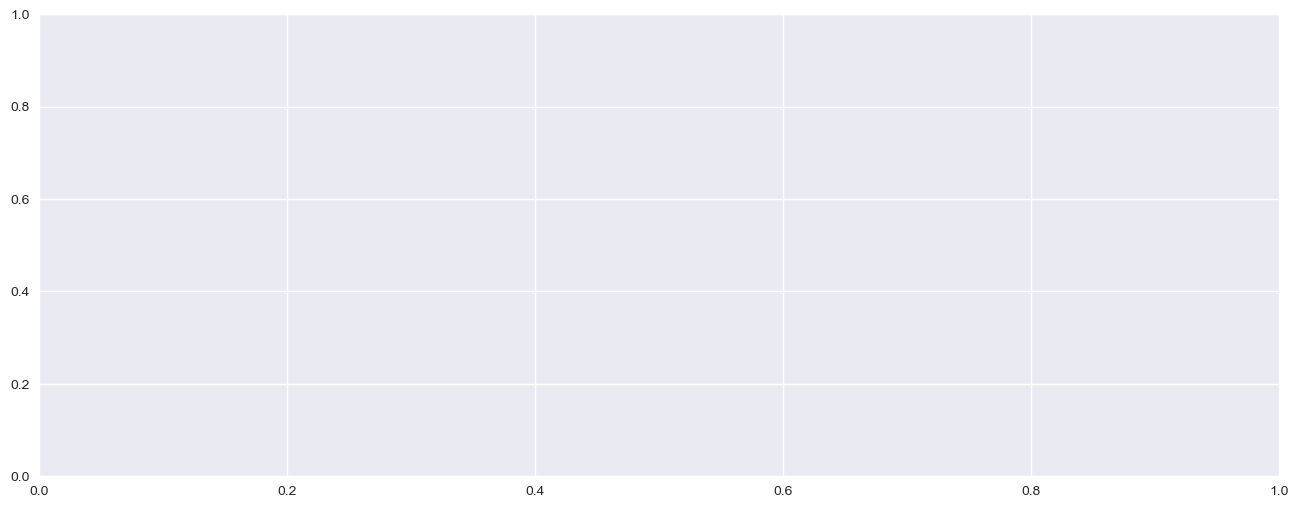

In [55]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
equalized.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

In [56]:
#del(news)
news = equalized.copy()
del(equalized)

NameError: name 'equalized' is not defined

### Word2Vec

In [14]:
from gensim.models import KeyedVectors

We load the vectors of a model trained by google with the texts of millions of news items

In [15]:
model = KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin.gz", binary=True,
                                          limit=50000)

An example printing words similar to trump

In [16]:
model.most_similar("Trump")

[('Donald_Trump', 0.8103920221328735),
 ('Apprentice', 0.4791555106639862),
 ('Paladino', 0.4655587673187256),
 ('Snooki', 0.44688403606414795),
 ('Harrah', 0.44451746344566345),
 ('MGM_Mirage', 0.44225355982780457),
 ('Vince_McMahon', 0.44097134470939636),
 ('Limbaugh', 0.4399240016937256),
 ('Palin', 0.4383709132671356),
 ('Giuliani', 0.4358449876308441)]

~~A continuación convertimos las palabras del título y contenido de las noticias en vectores numéricos para poder pasárselos a una red neuronal.~~

Convert the words in the news titles and content to Word2Vec vocabulary indices

In [17]:
news['title'] = news.progress_apply(lambda r: 
                    [model.key_to_index[x] for x in r['title'] if x in model.key_to_index], axis=1)

Pandas Apply:   0%|          | 0/119252 [00:00<?, ?it/s]

In [18]:
news['content'] = news.progress_apply(lambda r: 
                        [model.key_to_index[x] for x in r['content'] if x in model.key_to_index], axis=1)

Pandas Apply:   0%|          | 0/119252 [00:00<?, ?it/s]

Delete articles that do not have a title(Word2Vec did not have the original words)

In [19]:
news = news[news['title'].map(len) >= 1]

In [20]:
#Reset index
news = news.reset_index().drop("index", axis=1)

But there is a problem . The network input cannot be variable . To solve this, it is necessary to add padding to all arrays, so that they all have same physical length

If they measure less than a certain length n (l<n) then 'elements' with zeros will be added until the necessary dimensions are reached. If they measure more, they will be truncated in such a way that l=n

In [21]:
def pad_array(array, token_len):
    diff_token = token_len - len(array)
    if(diff_token < 0):
        array = array[:token_len] #Truncate
    else:
        #Pad
        array += [0]*diff_token #Pad
        
    return array  

In [22]:
news.head()

,type,content,title
0,truth,"[51, 4, 903, 387, 2087, 8, 21619, 9248, 5, 28,...","[13763, 3374, 1, 11, 17389, 531, 21619, 9923, ..."
1,truth,"[232, 71, 603, 4384, 3445, 1346, 911, 1144, 11...","[1674, 1037, 38, 141, 9923, 688, 2438]"
2,truth,"[62, 1364, 1082, 738, 46, 5320, 10034, 166, 25...","[4875, 1674, 172, 5294, 9923, 688, 2438]"
3,truth,"[7, 637, 11, 16301, 1828, 92, 13, 216, 1831, 1...","[16457, 1674, 11, 889, 9923, 688, 2438]"
4,truth,"[5124, 538, 4, 7683, 41, 46, 2034, 3770, 9252,...","[719, 2034, 3770, 9923, 688, 2438]"


It is necessary to find a  `token_len` that is sufficient to cover, in general, the length of all articles

In [23]:
tokens_numbers = news.swifter.apply(lambda row: len(row['content']), axis = 1)
tokens_numbers

Pandas Apply:   0%|          | 0/117565 [00:00<?, ?it/s]

0         644
1         678
2         676
3         683
4         581
         ... 
117560    392
117561    323
117562    838
117563    304
117564    913
Length: 117565, dtype: int64

<Axes: title={'center': 'Number of tokens in the article'}, ylabel='Frequency'>

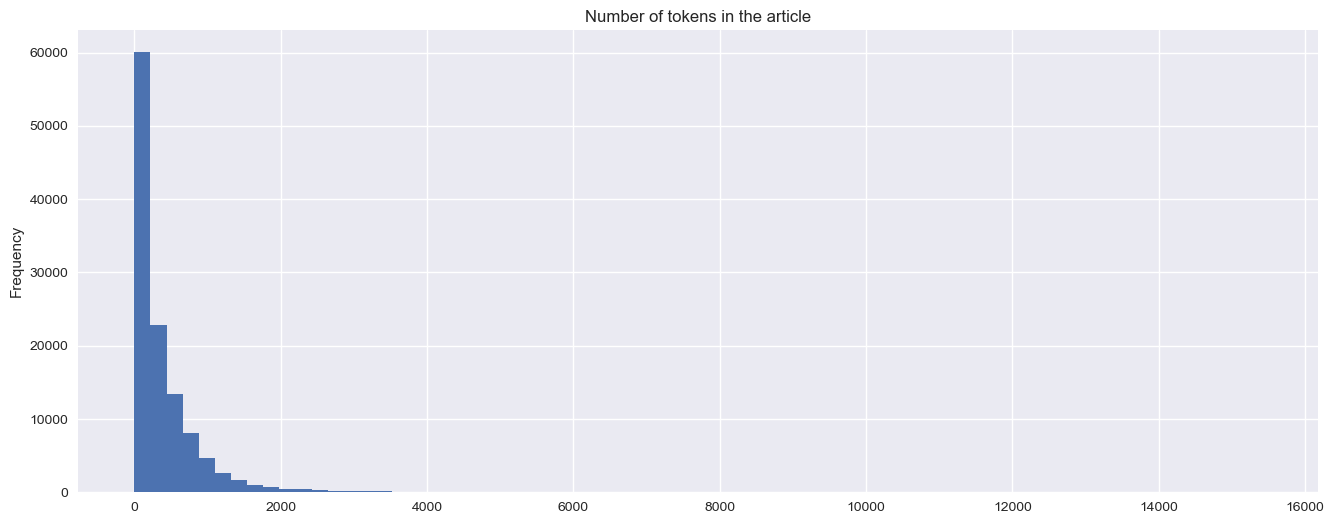

In [24]:
# Longitud en tokens de cada noticia
# tokens_numbers = news.swifter.apply(lambda row: len(row['content']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 70, ax=ax)

In [25]:
print("Average number of tokens per item: {}".format(int(np.mean(tokens_numbers))))
print("Standard deviation of tokens per item: {}".format(int(np.std(tokens_numbers))))
print("Median number of tokens per article: {}".format(int(np.median(tokens_numbers))))

Average number of tokens per item: 385
Standard deviation of tokens per item: 602
Median number of tokens per article: 210


We choose minimum number as $mean + 2\sigma$

In [26]:
max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Selected token window: {} - Covers {}% of dataset".format(max_tokens, percent_tokens*100))

Selected token window: 1590 - Covers 96.73542295751287% of dataset


In [27]:
n_tokens = max_tokens

In [28]:
news['content'] = news.apply(lambda r: pad_array(r['content'], n_tokens) , axis=1) #n_tokens

Same for titles

Número medio de tokens por título: 6
Desviación estándar de tokens por título: 3
Mediana de tokens por título: 7
Ventana de tokens escogida: 13 - Cubre el 96.47599200442308% del dataset


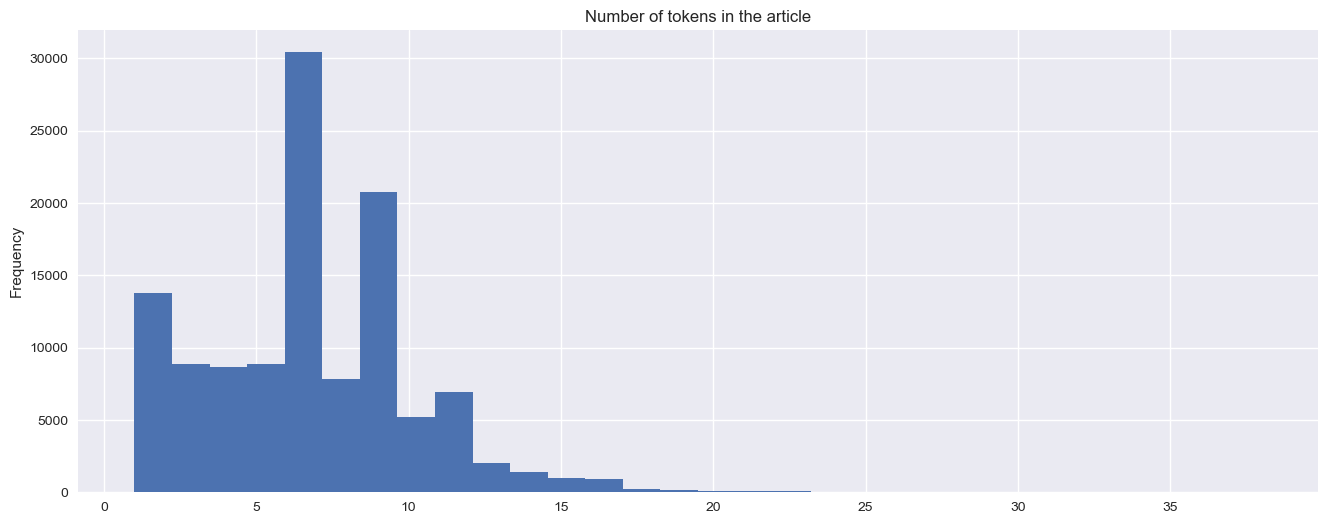

In [29]:
# Longitud en tokens de cada noticia
tokens_numbers = news.apply(lambda row: len(row['title']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 30, ax=ax)

print("Número medio de tokens por título: {}".format(int(np.mean(tokens_numbers))))
print("Desviación estándar de tokens por título: {}".format(int(np.std(tokens_numbers))))
print("Mediana de tokens por título: {}".format(int(np.median(tokens_numbers))))

max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

n_tokens = max_tokens

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Ventana de tokens escogida: {} - Cubre el {}% del dataset".format(max_tokens, percent_tokens*100))

In [30]:
news['title'] = news.progress_apply(lambda r: pad_array(r['title'], n_tokens) , axis=1)

Pandas Apply:   0%|          | 0/117565 [00:00<?, ?it/s]

### Convertir variable objetivo a OneHot Encodding

In [31]:
encoder = LabelBinarizer().fit(list(news['type']))
news['one_hot_label'] = news.apply(lambda r: encoder.transform([r['type']])[0], axis=1)

In [32]:
news.head()

,type,content,title,one_hot_label
0,truth,"[51, 4, 903, 387, 2087, 8, 21619, 9248, 5, 28,...","[13763, 3374, 1, 11, 17389, 531, 21619, 9923, ...",[1]
1,truth,"[232, 71, 603, 4384, 3445, 1346, 911, 1144, 11...","[1674, 1037, 38, 141, 9923, 688, 2438, 0, 0, 0...",[1]
2,truth,"[62, 1364, 1082, 738, 46, 5320, 10034, 166, 25...","[4875, 1674, 172, 5294, 9923, 688, 2438, 0, 0,...",[1]
3,truth,"[7, 637, 11, 16301, 1828, 92, 13, 216, 1831, 1...","[16457, 1674, 11, 889, 9923, 688, 2438, 0, 0, ...",[1]
4,truth,"[5124, 538, 4, 7683, 41, 46, 2034, 3770, 9252,...","[719, 2034, 3770, 9923, 688, 2438, 0, 0, 0, 0,...",[1]


In [33]:
news.tail()

,type,content,title,one_hot_label
117560,fake,"[169, 85, 15, 7687, 1244, 11, 1262, 640, 12654...","[3011, 10830, 3432, 5498, 1468, 33524, 2582, 3...",[0]
117561,fake,"[7196, 17, 9571, 7538, 430, 11134, 11, 1609, 3...","[17041, 17391, 97, 1954, 46781, 1867, 3512, 31...",[0]
117562,fake,"[1732, 4, 85, 706, 2, 11, 5218, 540, 58, 41890...","[167, 5918, 4, 85, 706, 2, 11, 5218, 540, 58, ...",[0]
117563,fake,"[17041, 17391, 97, 1954, 46781, 1867, 3512, 31...","[17041, 17391, 97, 1954, 46781, 1867, 3512, 31...",[0]
117564,fake,"[7196, 4532, 3755, 5597, 1190, 21656, 591, 198...","[3146, 16, 3755, 35304, 592, 7864, 21367, 2167...",[0]


We save the processed dataset as `.pickle` (serialized python objects).

In [34]:
news.to_pickle('../data/news_proc_12_3_19.pickle')


We save the processed dataset as `.csv`.

In [35]:
news.to_csv('../data/news_proc_8_3_19.csv', sep=';')

In [ ]:
from ast import literal_eval


In [ ]:
news = pd.read_csv('../data/news_proc_8_3_19.csv', 
                       sep=';', converters={'content':literal_eval, 
                                       'title':literal_eval, 
                                       'one_hot_label':literal_eval})

In [ ]:
#PROBAR A CARGAR Y LUEGO HACER UN APPLY PARALELIZADOb

In [ ]:
news = pd.read_csv('../data/news_proc_8_3_19.csv', sep=';')

In [ ]:
news['title'] = news.swifter.apply(lambda r: literal_eval(r['title']), axis= 1)
news['content'] = news.swifter.apply(lambda r: literal_eval(r['content']), axis= 1)
news['one_hot_label'] = news.swifter.apply(lambda r: literal_eval(r['one_hot_label']), axis= 1)